# 01 - Exploratory Data Analysis (EDA)
## LendingClub Loan Data - Policy Optimization Project

**Objectives:**
1. Understand dataset structure and quality
2. Identify missing values and data issues
3. Analyze class balance (default rates)
4. Examine temporal trends
5. Identify key features for modeling
6. **Critical: Determine if dataset contains only accepted loans**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Analysis Date: 2025-12-10 22:26:28


## 1. Data Loading & Basic Info

In [20]:
# Load data
DATA_PATH = '../accepted_2007_to_2018Q4.csv'

print("Loading dataset...")
df = pd.read_csv(DATA_PATH, low_memory=False)

print(f"\n{'='*60}")
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"{'='*60}")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading dataset...

Dataset Shape: 2,260,701 rows × 151 columns

Dataset Shape: 2,260,701 rows × 151 columns

Memory Usage: 5992.29 MB

Memory Usage: 5992.29 MB


In [21]:
# Display first few rows
print("\nFirst 5 rows:")
df.head()


First 5 rows:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Column info
print("\nColumn Information:")
df.info()


Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


## 2. Critical Check: Accepted-Only Dataset?

**This is crucial for RL formulation!**

In [23]:
# Check if we have loan_status (accepted) or application_type info
print("\n" + "="*60)
print("DATASET TYPE ANALYSIS")
print("="*60)

# Check unique loan statuses
if 'loan_status' in df.columns:
    print("\nLoan Status Distribution:")
    status_counts = df['loan_status'].value_counts()
    print(status_counts)
    print(f"\nUnique statuses: {df['loan_status'].nunique()}")
    
    # Check if there are any 'Rejected' or 'Denied' statuses
    rejected_keywords = ['reject', 'denied', 'decline']
    has_rejections = any(
        any(keyword in str(status).lower() for keyword in rejected_keywords)
        for status in df['loan_status'].unique()
    )
    
    print(f"\n⚠️  CRITICAL FINDING:")
    if has_rejections:
        print("✓ Dataset contains rejected applications")
    else:
        print("✗ Dataset contains ONLY ACCEPTED loans")
        print("  → This affects RL formulation (single action observed)")
        print("  → Will need synthetic denials or conservative OPE")
else:
    print("\n⚠️  WARNING: 'loan_status' column not found!")


DATASET TYPE ANALYSIS

Loan Status Distribution:
loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

Unique statuses: 9

⚠️  CRITICAL FINDING:
✗ Dataset contains ONLY ACCEPTED loans
  → This affects RL formulation (single action observed)
  → Will need synthetic denials or conservative OPE


## 3. Target Variable Creation & Analysis

In [24]:
# Create binary target: 0 = Fully Paid, 1 = Default/Charged Off
def map_target(status):
    """
    Map loan status to binary target:
    0 = Good (Fully Paid, Current)
    1 = Bad (Charged Off, Default)
    """
    status = str(status).lower()
    
    # Good outcomes
    if 'fully paid' in status or 'current' in status:
        return 0
    
    # Bad outcomes
    if 'charged off' in status or 'default' in status:
        return 1
    
    # Ambiguous - will drop later
    return np.nan

df['target'] = df['loan_status'].apply(map_target)

print("\nTarget Variable Mapping:")
print("0 = Fully Paid (Good)")
print("1 = Charged Off/Default (Bad)")
print("\nBefore dropping ambiguous statuses:")
print(df['target'].value_counts(dropna=False))

# Drop ambiguous statuses
n_before = len(df)
df = df.dropna(subset=['target'])
n_after = len(df)
print(f"\nDropped {n_before - n_after:,} ambiguous rows")
print(f"Remaining: {n_after:,} rows")


Target Variable Mapping:
0 = Fully Paid (Good)
1 = Charged Off/Default (Bad)

Before dropping ambiguous statuses:
target
0.0    1957056
1.0     269360
NaN      34285
Name: count, dtype: int64

Dropped 34,285 ambiguous rows
Remaining: 2,226,416 rows

Dropped 34,285 ambiguous rows
Remaining: 2,226,416 rows



CLASS BALANCE ANALYSIS

Fully Paid (0):  1,957,056 (87.90%)
Default (1):       269,360 (12.10%)

Default Rate: 12.10%
Imbalance Ratio: 7.27:1


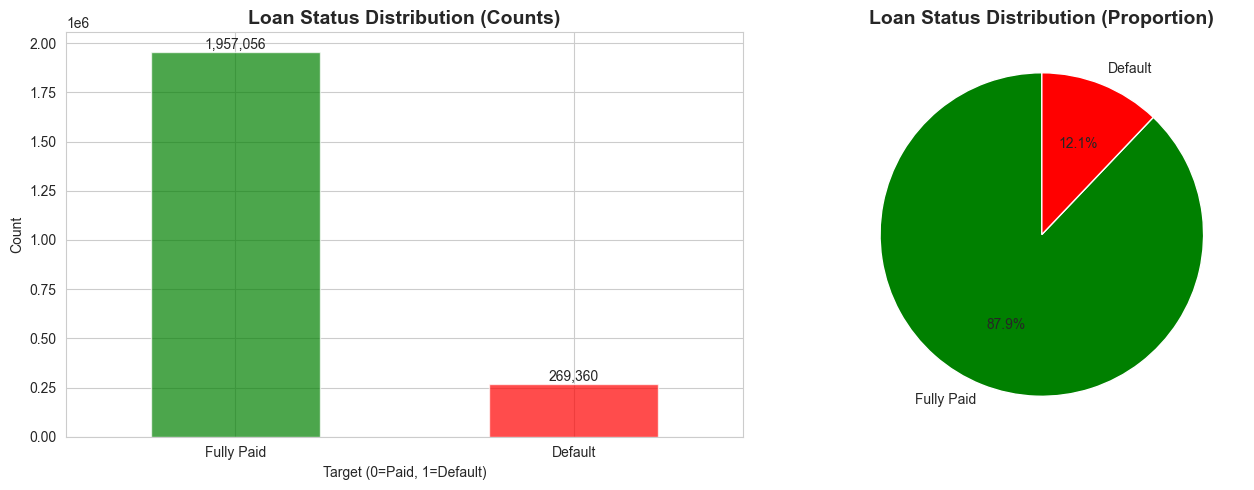


⚠️  Note: Class imbalance detected. Will use:
   - Weighted loss function in supervised model
   - Stratified splits
   - Appropriate evaluation metrics (AUC, F1, not just accuracy)


In [25]:
# Class balance analysis
print("\n" + "="*60)
print("CLASS BALANCE ANALYSIS")
print("="*60)

target_counts = df['target'].value_counts()
target_pct = df['target'].value_counts(normalize=True) * 100

print(f"\nFully Paid (0): {target_counts[0]:>10,} ({target_pct[0]:>5.2f}%)")
print(f"Default (1):    {target_counts[1]:>10,} ({target_pct[1]:>5.2f}%)")
print(f"\nDefault Rate: {target_pct[1]:.2f}%")
print(f"Imbalance Ratio: {target_counts[0] / target_counts[1]:.2f}:1")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
target_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Loan Status Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target (0=Paid, 1=Default)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Fully Paid', 'Default'], rotation=0)
for i, v in enumerate(target_counts):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Pie chart - removed alpha parameter as it's not supported
axes[1].pie(target_counts.values, labels=['Fully Paid', 'Default'], autopct='%1.1f%%',
            colors=['green', 'red'], startangle=90)
axes[1].set_title('Loan Status Distribution (Proportion)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/class_balance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n⚠️  Note: Class imbalance detected. Will use:")
print("   - Weighted loss function in supervised model")
print("   - Stratified splits")
print("   - Appropriate evaluation metrics (AUC, F1, not just accuracy)")


## 4. Missing Value Analysis


MISSING VALUE ANALYSIS (Top 30)

Columns with missing values: 113 / 152

Top 30 columns by missing percentage:

member_id                                     100.000000
orig_projected_additional_accrued_interest     99.703874
hardship_dpd                                   99.610630
hardship_payoff_balance_amount                 99.610630
hardship_reason                                99.610630
hardship_type                                  99.610630
hardship_amount                                99.610630
hardship_start_date                            99.610630
hardship_end_date                              99.610630
payment_plan_start_date                        99.610630
hardship_length                                99.610630
hardship_status                                99.610630
hardship_loan_status                           99.610630
deferral_term                                  99.610630
hardship_last_payment_amount                   99.610630
settlement_status               

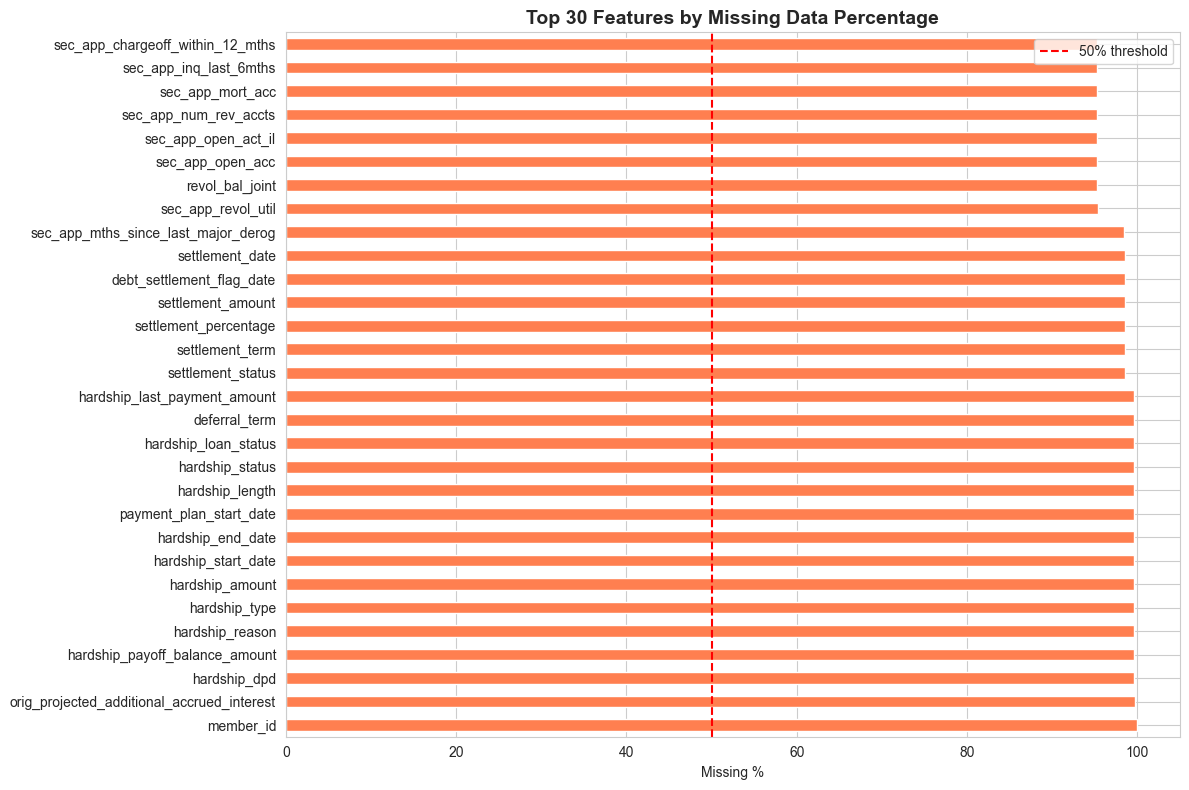


⚠️  Recommend dropping 44 columns with >50% missing:
['member_id', 'orig_projected_additional_accrued_interest', 'hardship_dpd', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_type', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date'] ...


In [26]:
# Calculate missing percentage
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

print("\n" + "="*60)
print(f"MISSING VALUE ANALYSIS (Top 30)")
print("="*60)
print(f"\nColumns with missing values: {len(missing_pct)} / {len(df.columns)}")
print("\nTop 30 columns by missing percentage:\n")
print(missing_pct.head(30))

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
missing_pct.head(30).plot(kind='barh', ax=ax, color='coral')
ax.set_title('Top 30 Features by Missing Data Percentage', fontsize=14, fontweight='bold')
ax.set_xlabel('Missing %')
ax.axvline(50, color='red', linestyle='--', label='50% threshold')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/missing_values.png', dpi=150, bbox_inches='tight')
plt.show()

# Columns to drop (>50% missing)
high_missing_cols = missing_pct[missing_pct > 50].index.tolist()
print(f"\n⚠️  Recommend dropping {len(high_missing_cols)} columns with >50% missing:")
print(high_missing_cols[:10], "..." if len(high_missing_cols) > 10 else "")

## 5. Temporal Analysis


TEMPORAL ANALYSIS

Loans issued per year:
issue_year
2007       603
2008      2393
2009      5281
2010     12537
2011     21721
2012     53367
2013    134810
2014    235022
2015    418845
2016    427166
2017    431172
2018    483499
dtype: int64

Default rate by year:
            Default Rate   Count
issue_year                      
2007           26.202322     603
2008           20.727121    2393
2009           13.690589    5281
2010           14.014517   12537
2011           15.178859   21721
2012           16.197275   53367
2013           15.595282  134810
2014           17.514105  235022
2015           18.098342  418845
2016           15.977863  427166
2017            9.084310  431172
2018            1.835371  483499


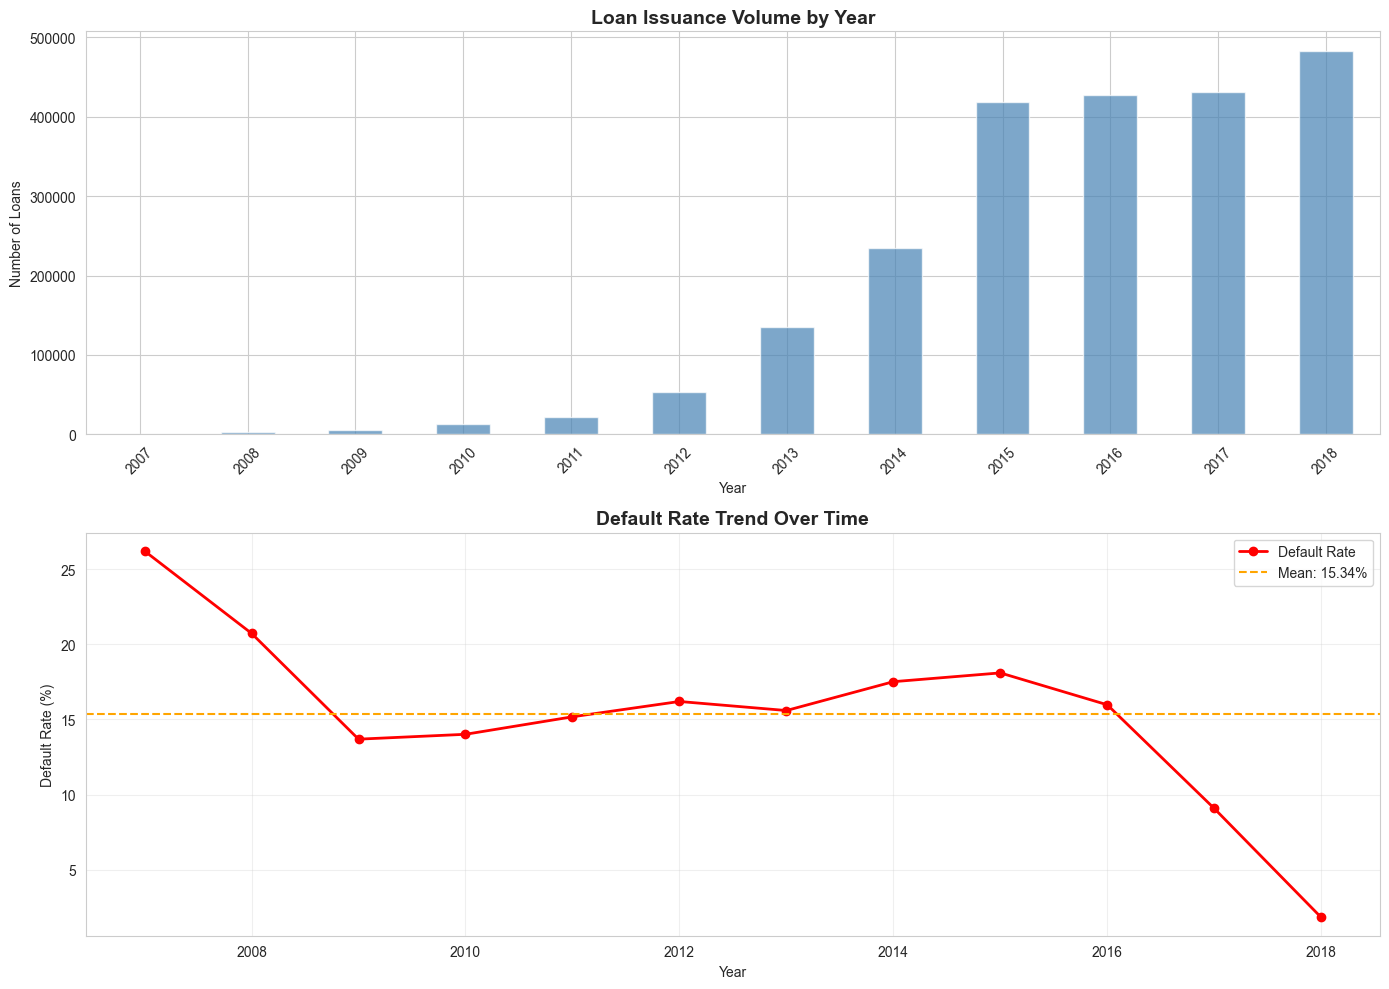


💡 Insight: Use temporal split for train/val/test (e.g., train 2007-2016, val 2017, test 2018)


In [27]:
# Parse issue date
if 'issue_d' in df.columns:
    df['issue_d_parsed'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
    df['issue_year'] = df['issue_d_parsed'].dt.year
    df['issue_month'] = df['issue_d_parsed'].dt.month
    
    print("\n" + "="*60)
    print("TEMPORAL ANALYSIS")
    print("="*60)
    
    # Loans by year
    loans_by_year = df.groupby('issue_year').size()
    print("\nLoans issued per year:")
    print(loans_by_year)
    
    # Default rate by year
    default_by_year = df.groupby('issue_year')['target'].agg(['mean', 'count'])
    default_by_year.columns = ['Default Rate', 'Count']
    default_by_year['Default Rate'] *= 100
    print("\nDefault rate by year:")
    print(default_by_year)
    
    # Visualization
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Loan volume over time
    loans_by_year.plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.7)
    axes[0].set_title('Loan Issuance Volume by Year', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Number of Loans')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Default rate over time
    default_by_year['Default Rate'].plot(kind='line', ax=axes[1], marker='o', 
                                          color='red', linewidth=2)
    axes[1].set_title('Default Rate Trend Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Default Rate (%)')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(default_by_year['Default Rate'].mean(), color='orange', 
                    linestyle='--', label=f'Mean: {default_by_year["Default Rate"].mean():.2f}%')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('../reports/temporal_trends.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n💡 Insight: Use temporal split for train/val/test (e.g., train 2007-2016, val 2017, test 2018)")
else:
    print("\n⚠️  'issue_d' column not found - cannot perform temporal analysis")

### 5.1 Enhanced Default Probability Timeline ⭐

**Visualize the 2007-2008 Financial Crisis Impact**


DEFAULT PROBABILITY TIMELINE (Financial Crisis Impact)

Year-by-year breakdown:
            Default Rate  Total Defaults  Total Loans
issue_year                                           
2007           26.202322           158.0          603
2008           20.727121           496.0         2393
2009           13.690589           723.0         5281
2010           14.014517          1757.0        12537
2011           15.178859          3297.0        21721
2012           16.197275          8644.0        53367
2013           15.595282         21024.0       134810
2014           17.514105         41162.0       235022
2015           18.098342         75804.0       418845
2016           15.977863         68252.0       427166
2017            9.084310         39169.0       431172
2018            1.835371          8874.0       483499


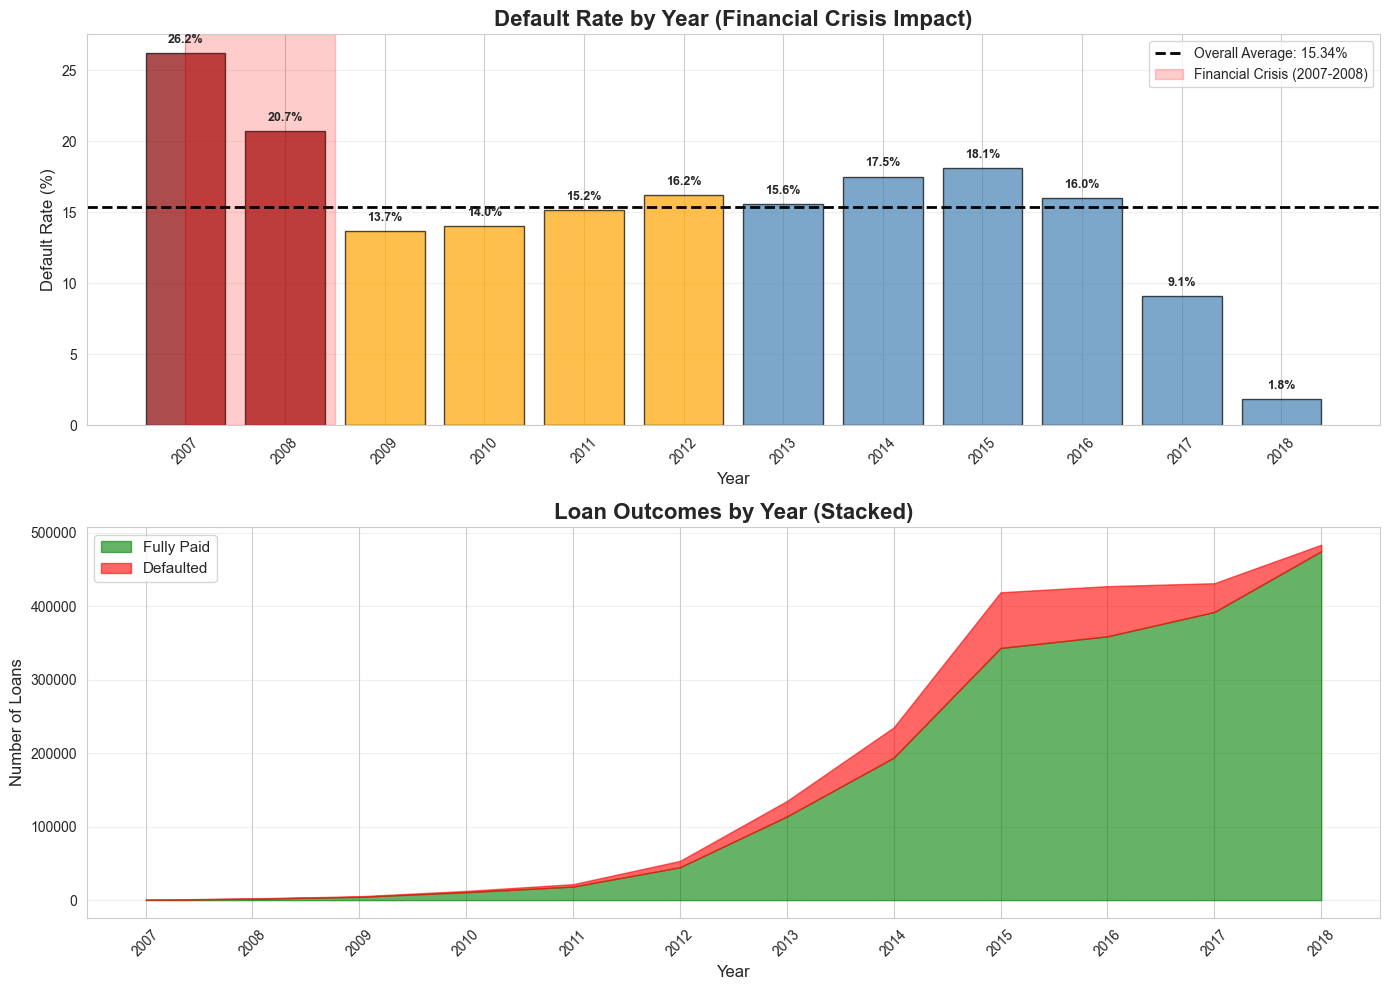


💡 Key Findings:
   - 2007 Crisis Peak: 26.20% default rate
   - 2008 Aftermath: 20.73% default rate
   - Recovery (2010): 14.01% default rate
   - Recent (2017): 9.08% default rate
   - Most Recent (2018): 1.84% (loans too new!)

   → Financial crisis clearly visible in default spike
   → Temporal split critical: train on crisis data, test on stable economy
   → 2018 artificially low (loans haven't matured yet)


In [38]:
# Enhanced visualization: Default probability over time with crisis annotation
if 'issue_year' in df.columns:
    print("\n" + "="*60)
    print("DEFAULT PROBABILITY TIMELINE (Financial Crisis Impact)")
    print("="*60)
    
    # Calculate detailed statistics by year
    yearly_stats = df.groupby('issue_year').agg({
        'target': ['mean', 'sum', 'count']
    })
    yearly_stats.columns = ['Default Rate', 'Total Defaults', 'Total Loans']
    yearly_stats['Default Rate'] *= 100
    
    print("\nYear-by-year breakdown:")
    print(yearly_stats)
    
    # Create enhanced visualization
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Default Rate Timeline with Crisis Highlighting
    years = yearly_stats.index
    default_rates = yearly_stats['Default Rate']
    
    # Color bars by era
    colors = []
    for year in years:
        if year <= 2008:
            colors.append('darkred')  # Crisis period
        elif year <= 2012:
            colors.append('orange')    # Recovery period
        else:
            colors.append('steelblue') # Stable period
    
    axes[0].bar(years, default_rates, color=colors, alpha=0.7, edgecolor='black')
    axes[0].set_title('Default Rate by Year (Financial Crisis Impact)', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Year', fontsize=12)
    axes[0].set_ylabel('Default Rate (%)', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add average line
    avg_rate = default_rates.mean()
    axes[0].axhline(avg_rate, color='black', linestyle='--', linewidth=2, 
                    label=f'Overall Average: {avg_rate:.2f}%')
    
    # Annotate crisis period
    axes[0].axvspan(2007, 2008.5, alpha=0.2, color='red', label='Financial Crisis (2007-2008)')
    
    # Add value labels on bars
    for i, (year, rate) in enumerate(zip(years, default_rates)):
        axes[0].text(year, rate + 0.5, f'{rate:.1f}%', ha='center', va='bottom', 
                    fontweight='bold', fontsize=9)
    
    axes[0].legend(loc='upper right', fontsize=10)
    axes[0].set_xticks(years)
    axes[0].set_xticklabels(years, rotation=45)
    
    # Plot 2: Stacked area showing Defaults vs Fully Paid
    fully_paid = yearly_stats['Total Loans'] - yearly_stats['Total Defaults']
    defaults = yearly_stats['Total Defaults']
    
    axes[1].fill_between(years, 0, fully_paid, label='Fully Paid', color='green', alpha=0.6)
    axes[1].fill_between(years, fully_paid, fully_paid + defaults, 
                        label='Defaulted', color='red', alpha=0.6)
    axes[1].set_title('Loan Outcomes by Year (Stacked)', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Year', fontsize=12)
    axes[1].set_ylabel('Number of Loans', fontsize=12)
    axes[1].legend(loc='upper left', fontsize=11)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_xticks(years)
    axes[1].set_xticklabels(years, rotation=45)
    
    plt.tight_layout()
    plt.savefig('../reports/figures/default_probability_timeline.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n💡 Key Findings:")
    print(f"   - 2007 Crisis Peak: {yearly_stats.loc[2007, 'Default Rate']:.2f}% default rate")
    print(f"   - 2008 Aftermath: {yearly_stats.loc[2008, 'Default Rate']:.2f}% default rate")
    print(f"   - Recovery (2010): {yearly_stats.loc[2010, 'Default Rate']:.2f}% default rate")
    print(f"   - Recent (2017): {yearly_stats.loc[2017, 'Default Rate']:.2f}% default rate")
    print(f"   - Most Recent (2018): {yearly_stats.loc[2018, 'Default Rate']:.2f}% (loans too new!)")
    print("\n   → Financial crisis clearly visible in default spike")
    print("   → Temporal split critical: train on crisis data, test on stable economy")
    print("   → 2018 artificially low (loans haven't matured yet)")

## 6. Key Numeric Features Distribution


NUMERIC FEATURES DISTRIBUTION

Summary Statistics:
          loan_amnt      int_rate   installment    annual_inc           dti  \
count  2.226416e+06  2.226416e+06  2.226416e+06  2.226412e+06  2.224743e+06   
mean   1.501409e+04  1.305479e+01  4.448701e+02  7.798690e+04  1.880359e+01   
std    9.177771e+03  4.814616e+00  2.667323e+02  1.130947e+05  1.412847e+01   
min    5.000000e+02  5.310000e+00  4.930000e+00  0.000000e+00 -1.000000e+00   
25%    8.000000e+03  9.490000e+00  2.513600e+02  4.600000e+04  1.189000e+01   
50%    1.280000e+04  1.262000e+01  3.773700e+02  6.500000e+04  1.782000e+01   
75%    2.000000e+04  1.588000e+01  5.910200e+02  9.300000e+04  2.447000e+01   
max    4.000000e+04  3.099000e+01  1.719830e+03  1.100000e+08  9.990000e+02   

          revol_bal    revol_util  fico_range_low  fico_range_high  \
count  2.226416e+06  2.224652e+06    2.226416e+06     2.226416e+06   
mean   1.667642e+04  5.033466e+01    6.986866e+02     7.026868e+02   
std    2.297960e+04  2.470

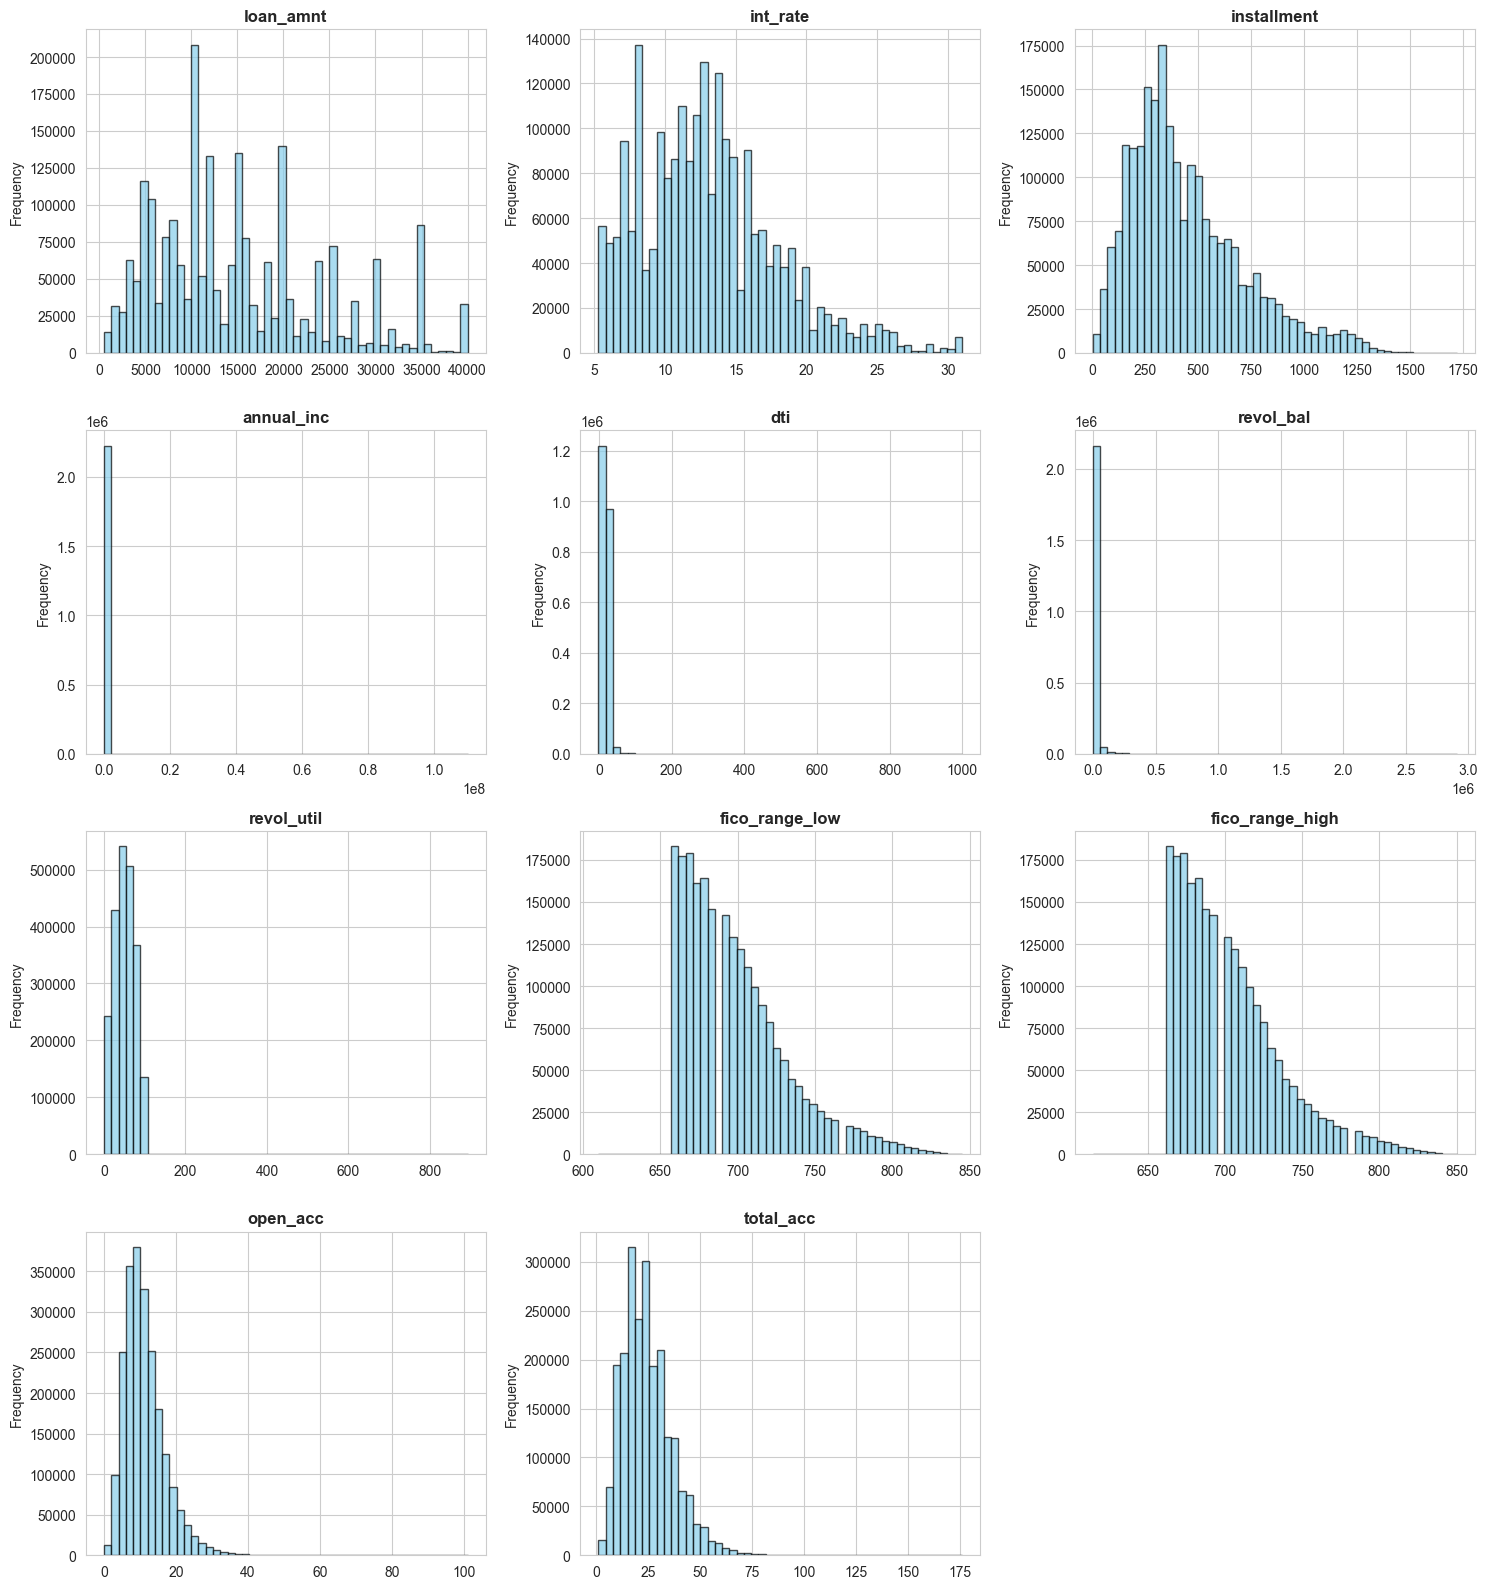

In [39]:
# Key numeric features to analyze
key_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
                'revol_bal', 'revol_util', 'fico_range_low', 'fico_range_high',
                'open_acc', 'total_acc']

# Filter existing columns
key_features = [f for f in key_features if f in df.columns]

print("\n" + "="*60)
print("NUMERIC FEATURES DISTRIBUTION")
print("="*60)

# Summary statistics
print("\nSummary Statistics:")
print(df[key_features].describe())

# Distribution plots
n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(key_features):
    if feature in df.columns:
        df[feature].hist(bins=50, ax=axes[idx], color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Frequency')

# Hide empty subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../reports/numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Categorical Features Analysis

In [29]:
# Key categorical features
cat_features = ['term', 'grade', 'sub_grade', 'home_ownership', 
                'verification_status', 'purpose', 'addr_state']

# Filter existing columns
cat_features = [f for f in cat_features if f in df.columns]

print("\n" + "="*60)
print("CATEGORICAL FEATURES ANALYSIS")
print("="*60)

for feature in cat_features:
    print(f"\n{feature}:")
    print(f"  Unique values: {df[feature].nunique()}")
    print(f"  Missing: {df[feature].isnull().sum()} ({df[feature].isnull().mean()*100:.2f}%)")
    if df[feature].nunique() <= 10:
        print(f"\n  Value counts:")
        print(df[feature].value_counts())


CATEGORICAL FEATURES ANALYSIS

term:
  Unique values: 2
  Missing: 0 (0.00%)

  Value counts:
term
36 months    1589901
60 months     636515
Name: count, dtype: int64

grade:
  Unique values: 7
  Missing: 0 (0.00%)

  Value counts:
grade
B    656005
C    638030
A    430732
D    316795
E    132272
F     40791
G     11791
Name: count, dtype: int64

sub_grade:
  Unique values: 35
  Missing: 0 (0.00%)

home_ownership:
  Missing: 0 (0.00%)

  Value counts:
grade
B    656005
C    638030
A    430732
D    316795
E    132272
F     40791
G     11791
Name: count, dtype: int64

sub_grade:
  Unique values: 35
  Missing: 0 (0.00%)

home_ownership:
  Unique values: 6
  Missing: 0 (0.00%)

  Value counts:
home_ownership
MORTGAGE    1096160
RENT         880180
OWN          248869
ANY             971
OTHER           182
NONE             54
Name: count, dtype: int64

verification_status:
  Unique values: 3
  Unique values: 6
  Missing: 0 (0.00%)

  Value counts:
home_ownership
MORTGAGE    1096160
RENT  


DEFAULT RATE BY CATEGORICAL FEATURES

GRADE:
       Default Rate   Count
grade                      
G         39.284200   11791
F         35.755436   40791
E         27.367092  132272
D         19.338689  316795
C         13.448427  638030
B          8.027530  656005
A          3.299964  430732


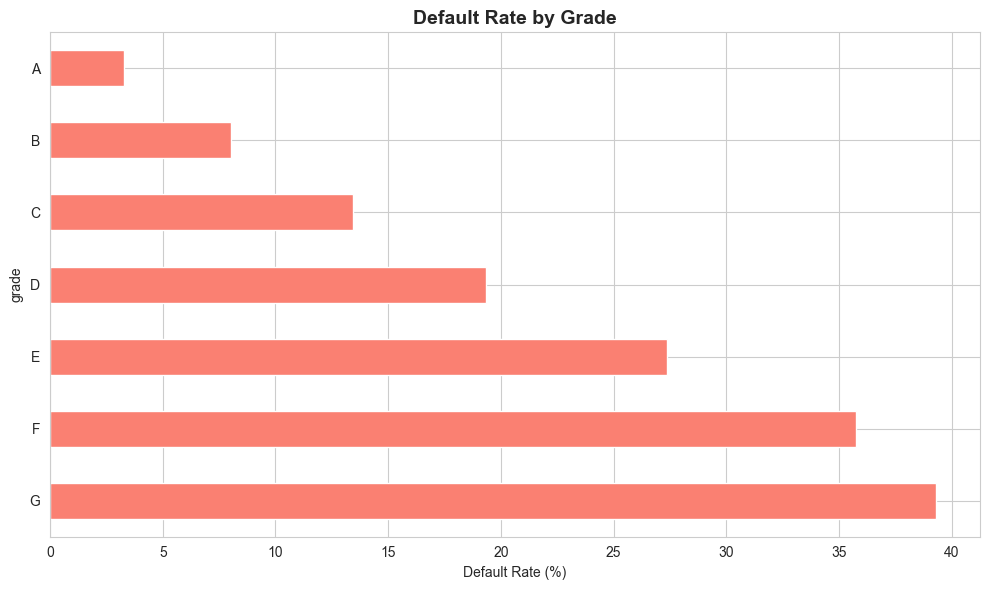


HOME_OWNERSHIP:
                Default Rate    Count
home_ownership                       
OTHER              20.879121      182
NONE               14.814815       54
RENT               14.138131   880180
OWN                12.022791   248869
MORTGAGE           10.481682  1096160
ANY                 5.767250      971


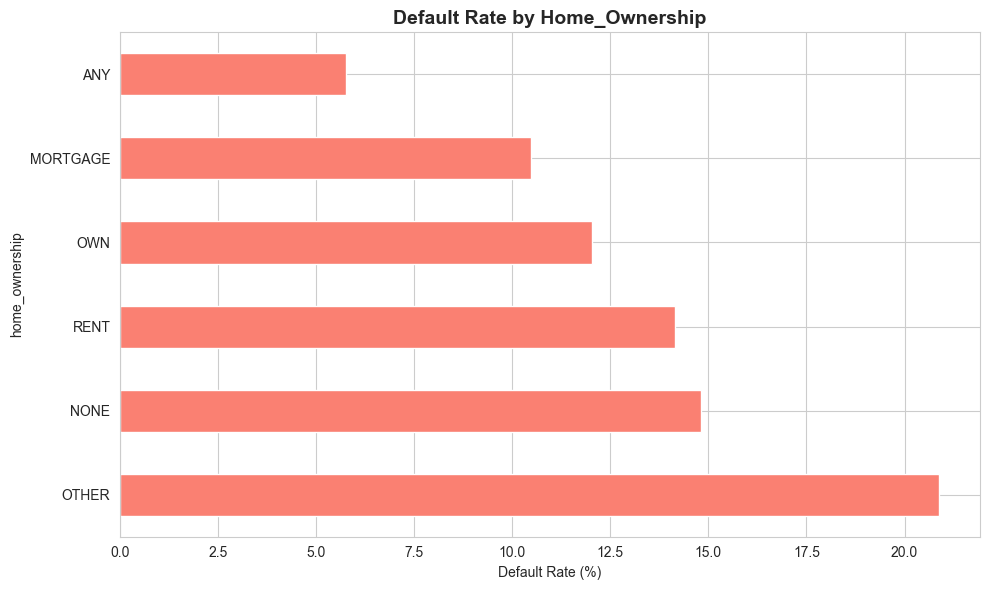


PURPOSE:
                    Default Rate    Count
purpose                                  
educational            20.754717      424
small_business         19.248593    24168
renewable_energy       15.568022     1426
moving                 14.739139    15123
debt_consolidation     13.143284  1257882
medical                12.615112    27039
wedding                12.399151     2355
other                  12.053506   136956
house                  11.548462    13846
vacation               11.397948    15301
major_purchase         11.088702    49582
home_improvement       10.514875   148133
credit_card             9.806157   510465
car                     9.095126    23716


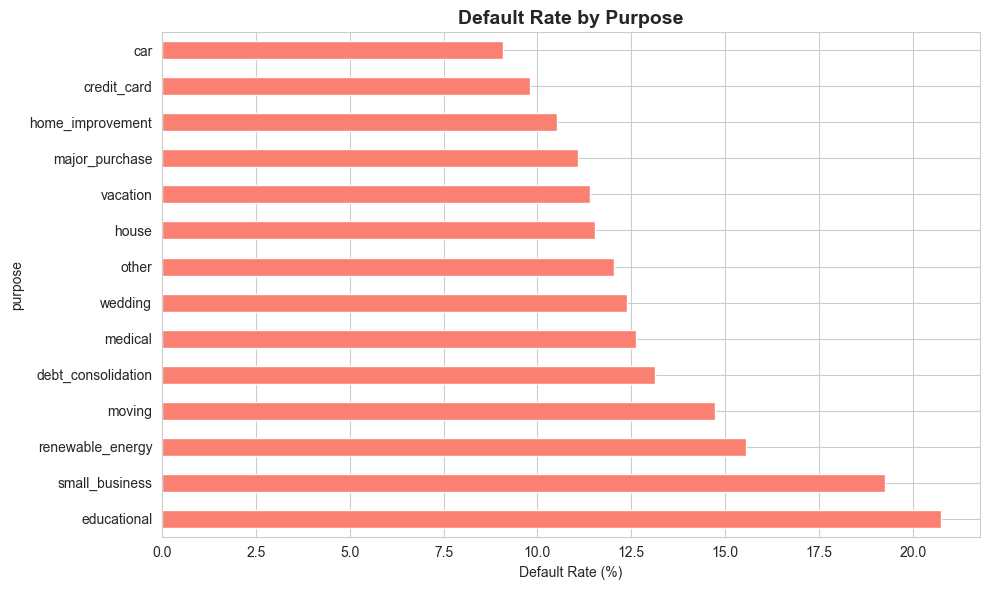


VERIFICATION_STATUS:
                     Default Rate   Count
verification_status                      
Verified                16.151394  618993
Source Verified         12.541022  871779
Not Verified             8.163459  735644


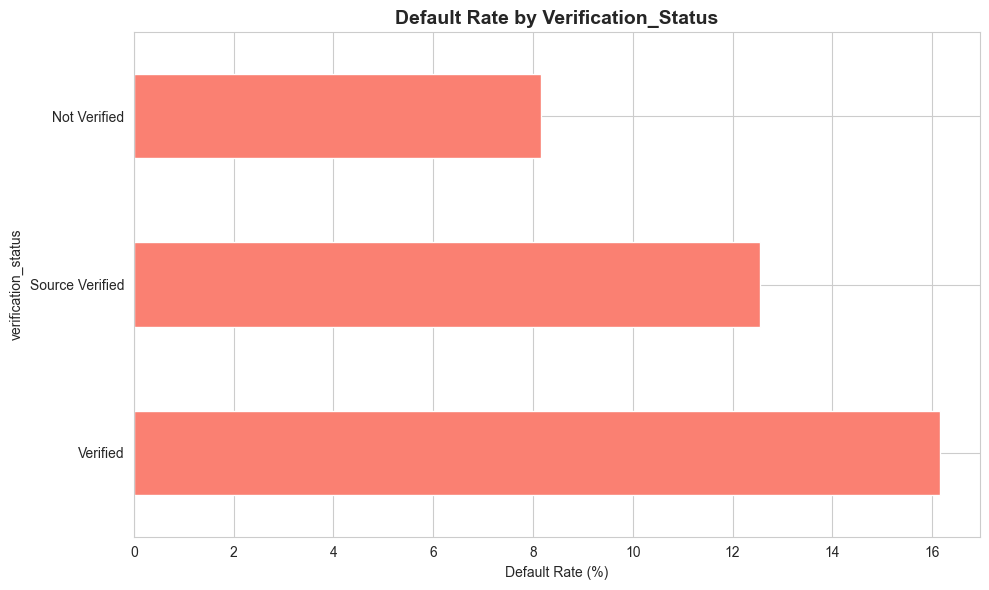

In [40]:
# Default rate by categorical features
print("\n" + "="*60)
print("DEFAULT RATE BY CATEGORICAL FEATURES")
print("="*60)

for feature in ['grade', 'home_ownership', 'purpose', 'verification_status']:
    if feature in df.columns:
        default_by_cat = df.groupby(feature)['target'].agg(['mean', 'count'])
        default_by_cat.columns = ['Default Rate', 'Count']
        default_by_cat['Default Rate'] *= 100
        default_by_cat = default_by_cat.sort_values('Default Rate', ascending=False)
        
        print(f"\n{feature.upper()}:")
        print(default_by_cat)
        
        # Plot top categories
        if len(default_by_cat) <= 15:
            fig, ax = plt.subplots(figsize=(10, 6))
            default_by_cat['Default Rate'].plot(kind='barh', ax=ax, color='salmon')
            ax.set_title(f'Default Rate by {feature.title()}', fontsize=14, fontweight='bold')
            ax.set_xlabel('Default Rate (%)')
            plt.tight_layout()
            plt.savefig(f'../reports/default_by_{feature}.png', dpi=150, bbox_inches='tight')
            plt.show()

### 7.1 Profit Distribution by Grade ⭐

**Key Insight**: Not just default rate, but actual profit/loss varies dramatically by grade!


PROFIT DISTRIBUTION BY GRADE

Profit statistics by grade:
           median         mean           std   count
grade                                               
A      161.143718 -3772.787965   7644.133149  430732
B      304.440000 -2834.452844   7328.617254  656005
C       95.699953 -2875.299731   7623.983986  638030
D       94.950952 -2607.694767   8131.806449  316795
E      343.765000 -1583.252019   8724.353424  132272
F      514.720000 -1339.952273   9894.431231   40791
G     -473.560000 -2242.218092  10625.357925   11791


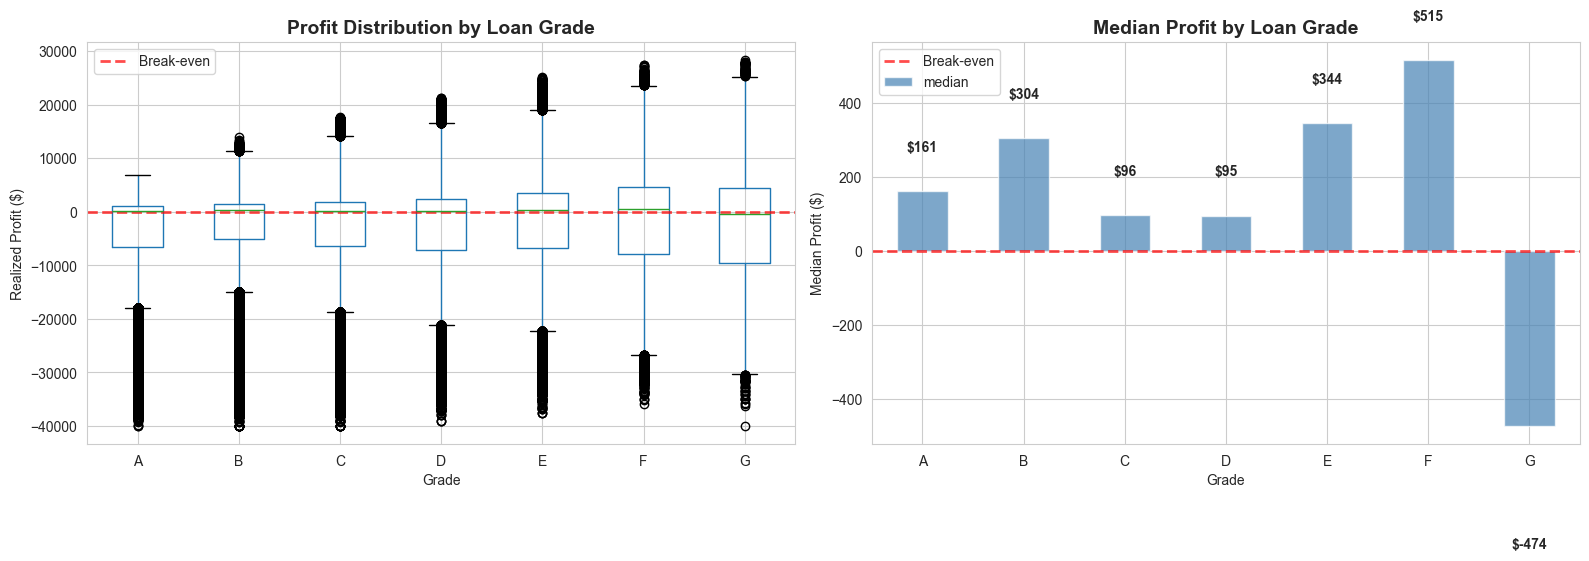


💡 Key Insight:
   - Grade A median profit: $161.14
   - Grade G median profit: $-473.56
   - Difference: $634.70

   → Higher grades are consistently more profitable!
   → This motivates PROFIT optimization, not just default prediction


In [41]:
# Profit distribution by grade (if profit already calculated)
if 'realized_profit' in df.columns and 'grade' in df.columns:
    print("\n" + "="*60)
    print("PROFIT DISTRIBUTION BY GRADE")
    print("="*60)
    
    # Calculate statistics by grade
    profit_by_grade = df.groupby('grade')['realized_profit'].agg([
        ('median', 'median'),
        ('mean', 'mean'),
        ('std', 'std'),
        ('count', 'count')
    ]).sort_index()
    
    print("\nProfit statistics by grade:")
    print(profit_by_grade)
    
    # Visualization: Boxplot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Boxplot
    df.boxplot(column='realized_profit', by='grade', ax=axes[0])
    axes[0].set_title('Profit Distribution by Loan Grade', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Grade')
    axes[0].set_ylabel('Realized Profit ($)')
    axes[0].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Break-even')
    axes[0].legend()
    plt.suptitle('')  # Remove auto title
    
    # Bar plot of median profit by grade
    profit_by_grade['median'].plot(kind='bar', ax=axes[1], color='steelblue', alpha=0.7)
    axes[1].set_title('Median Profit by Loan Grade', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Grade')
    axes[1].set_ylabel('Median Profit ($)')
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Break-even')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
    axes[1].legend()
    
    # Add value labels on bars
    for i, v in enumerate(profit_by_grade['median']):
        axes[1].text(i, v + 100 if v > 0 else v - 300, f'${v:,.0f}', 
                    ha='center', va='bottom' if v > 0 else 'top', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/profit_by_grade.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n💡 Key Insight:")
    print(f"   - Grade A median profit: ${profit_by_grade.loc['A', 'median']:,.2f}")
    print(f"   - Grade G median profit: ${profit_by_grade.loc['G', 'median']:,.2f}")
    print(f"   - Difference: ${profit_by_grade.loc['A', 'median'] - profit_by_grade.loc['G', 'median']:,.2f}")
    print("\n   → Higher grades are consistently more profitable!")
    print("   → This motivates PROFIT optimization, not just default prediction")

### 7.2 Interest Rate vs Profit Relationship ⭐

**Key Insight**: High interest rates create a risk-reward tradeoff - more profit when paid, but higher default risk!


INTEREST RATE vs PROFIT ANALYSIS

Profit by interest rate bin and loan status:
                          median         mean   count
int_rate_bin target                                  
<7%          0.0      264.365404 -3773.467335  180831
             1.0    -4486.865000 -6179.603818    4432
7-10%        0.0      407.210000 -2627.795179  434854
             1.0    -4670.110000 -6353.311102   26264
10-13%       0.0      439.144908 -2609.655170  518264
             1.0    -4784.800000 -6352.999208   55094
13-16%       0.0      752.189998 -1652.947533  400541
             1.0    -5417.090000 -6825.171516   68438
16-20%       0.0      751.069046 -1633.240106  294264
             1.0    -6374.310000 -7602.330048   71404
>20%         0.0      585.140000 -1114.997780  122343
             1.0    -8097.120000 -8991.387714   41422


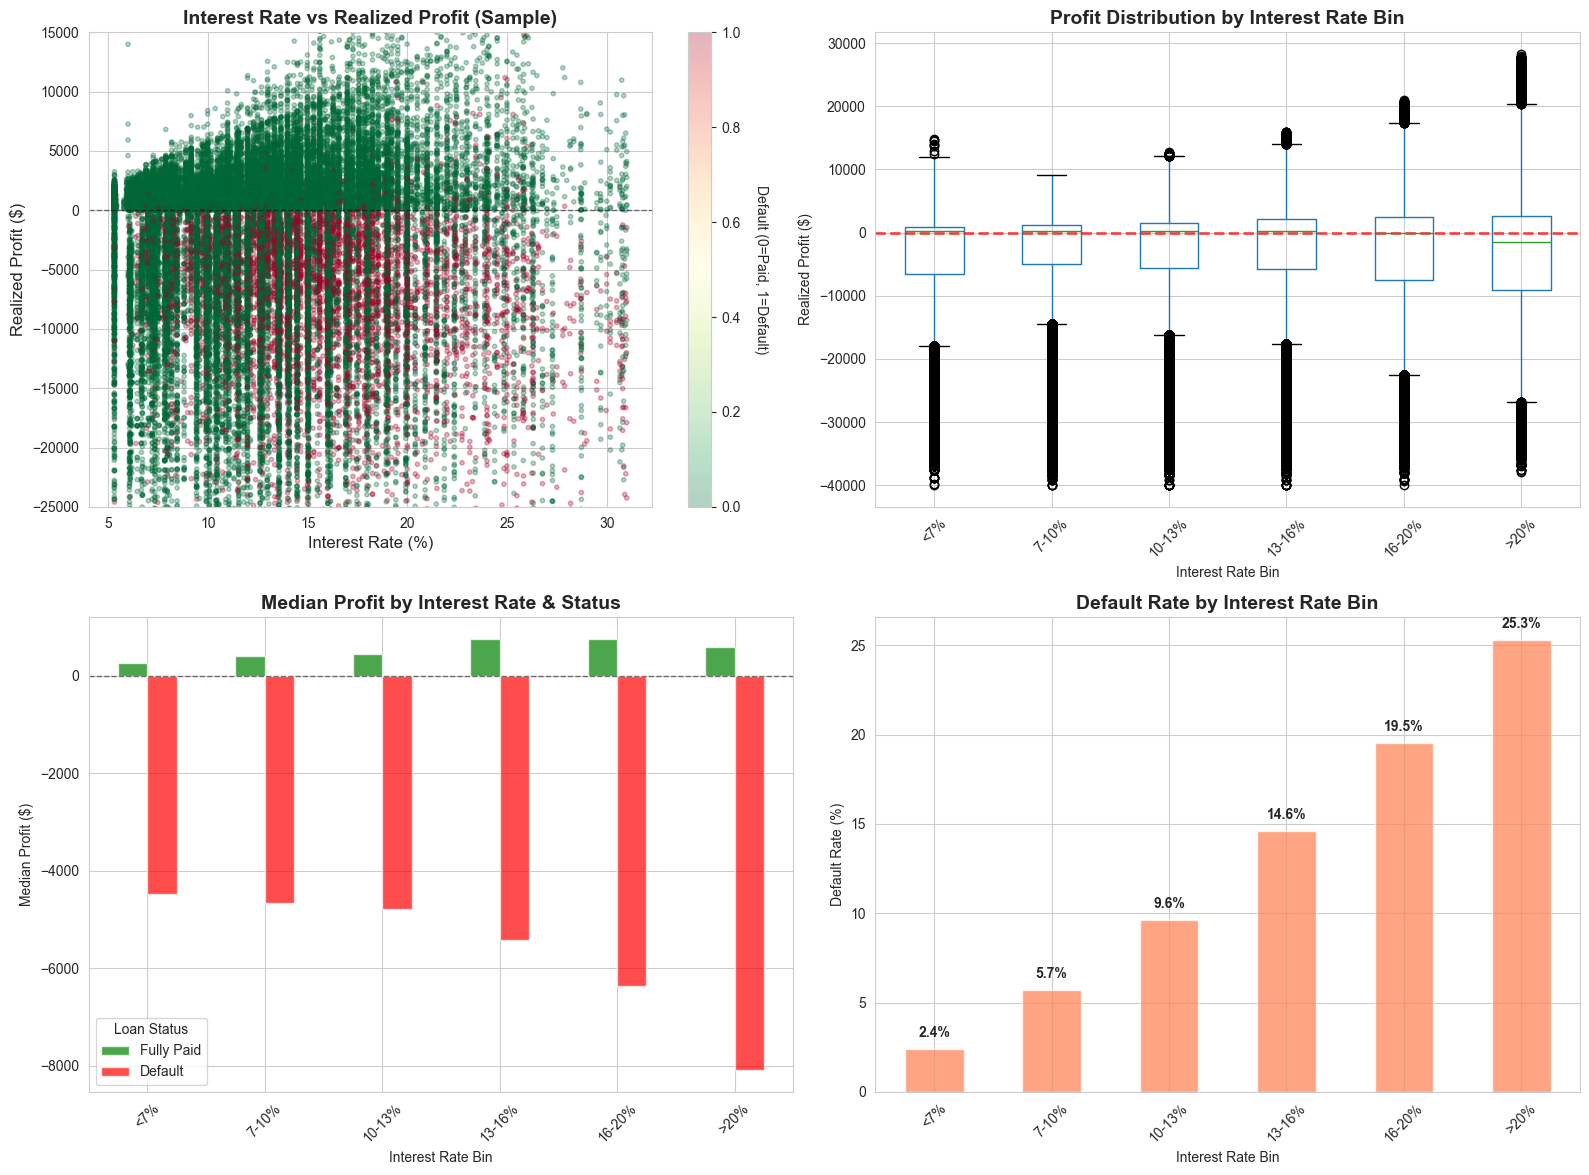


💡 Key Insights:
   1. HIGHER interest rates → HIGHER profit when loan is fully paid
   2. HIGHER interest rates → HIGHER default risk
   3. This creates a U-SHAPED RISK PROFILE:
      - Too low rate → low profit
      - Too high rate → high default risk
      - Optimal rate exists in the middle

   → Motivates RL: Supervised classifiers optimize accuracy,
     but RL can optimize PROFIT by balancing risk vs reward!


In [42]:
# Interest rate vs profit analysis
if 'realized_profit' in df.columns and 'int_rate' in df.columns:
    print("\n" + "="*60)
    print("INTEREST RATE vs PROFIT ANALYSIS")
    print("="*60)
    
    # Create interest rate bins
    df['int_rate_bin'] = pd.cut(df['int_rate'], bins=[0, 7, 10, 13, 16, 20, 30], 
                                  labels=['<7%', '7-10%', '10-13%', '13-16%', '16-20%', '>20%'])
    
    # Analyze by interest rate bin and default status
    profit_by_rate = df.groupby(['int_rate_bin', 'target'])['realized_profit'].agg(['median', 'mean', 'count'])
    print("\nProfit by interest rate bin and loan status:")
    print(profit_by_rate)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Scatter plot (sample for performance)
    sample_df = df.sample(n=min(50000, len(df)), random_state=42)
    scatter = axes[0, 0].scatter(sample_df['int_rate'], sample_df['realized_profit'], 
                                  c=sample_df['target'], cmap='RdYlGn_r', alpha=0.3, s=10)
    axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 0].set_xlabel('Interest Rate (%)', fontsize=12)
    axes[0, 0].set_ylabel('Realized Profit ($)', fontsize=12)
    axes[0, 0].set_title('Interest Rate vs Realized Profit (Sample)', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylim(-25000, 15000)
    cbar = plt.colorbar(scatter, ax=axes[0, 0])
    cbar.set_label('Default (0=Paid, 1=Default)', rotation=270, labelpad=20)
    
    # 2. Boxplot by interest rate bin
    df.boxplot(column='realized_profit', by='int_rate_bin', ax=axes[0, 1])
    axes[0, 1].set_title('Profit Distribution by Interest Rate Bin', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Interest Rate Bin')
    axes[0, 1].set_ylabel('Realized Profit ($)')
    axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    axes[0, 1].tick_params(axis='x', rotation=45)
    plt.suptitle('')
    
    # 3. Median profit by rate bin, split by default status
    profit_pivot = df.groupby(['int_rate_bin', 'target'])['realized_profit'].median().unstack()
    profit_pivot.columns = ['Fully Paid', 'Default']
    profit_pivot.plot(kind='bar', ax=axes[1, 0], color=['green', 'red'], alpha=0.7)
    axes[1, 0].set_title('Median Profit by Interest Rate & Status', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Interest Rate Bin')
    axes[1, 0].set_ylabel('Median Profit ($)')
    axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
    axes[1, 0].legend(title='Loan Status')
    
    # 4. Default rate by interest rate bin
    default_by_rate = df.groupby('int_rate_bin')['target'].agg(['mean', 'count'])
    default_by_rate['mean'] *= 100
    default_by_rate['mean'].plot(kind='bar', ax=axes[1, 1], color='coral', alpha=0.7)
    axes[1, 1].set_title('Default Rate by Interest Rate Bin', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Interest Rate Bin')
    axes[1, 1].set_ylabel('Default Rate (%)')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
    
    # Add value labels
    for i, v in enumerate(default_by_rate['mean']):
        axes[1, 1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/interest_rate_vs_profit.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n💡 Key Insights:")
    print("   1. HIGHER interest rates → HIGHER profit when loan is fully paid")
    print("   2. HIGHER interest rates → HIGHER default risk")
    print("   3. This creates a U-SHAPED RISK PROFILE:")
    print("      - Too low rate → low profit")
    print("      - Too high rate → high default risk")
    print("      - Optimal rate exists in the middle")
    print("\n   → Motivates RL: Supervised classifiers optimize accuracy,")
    print("     but RL can optimize PROFIT by balancing risk vs reward!")

## 8. Correlation Analysis

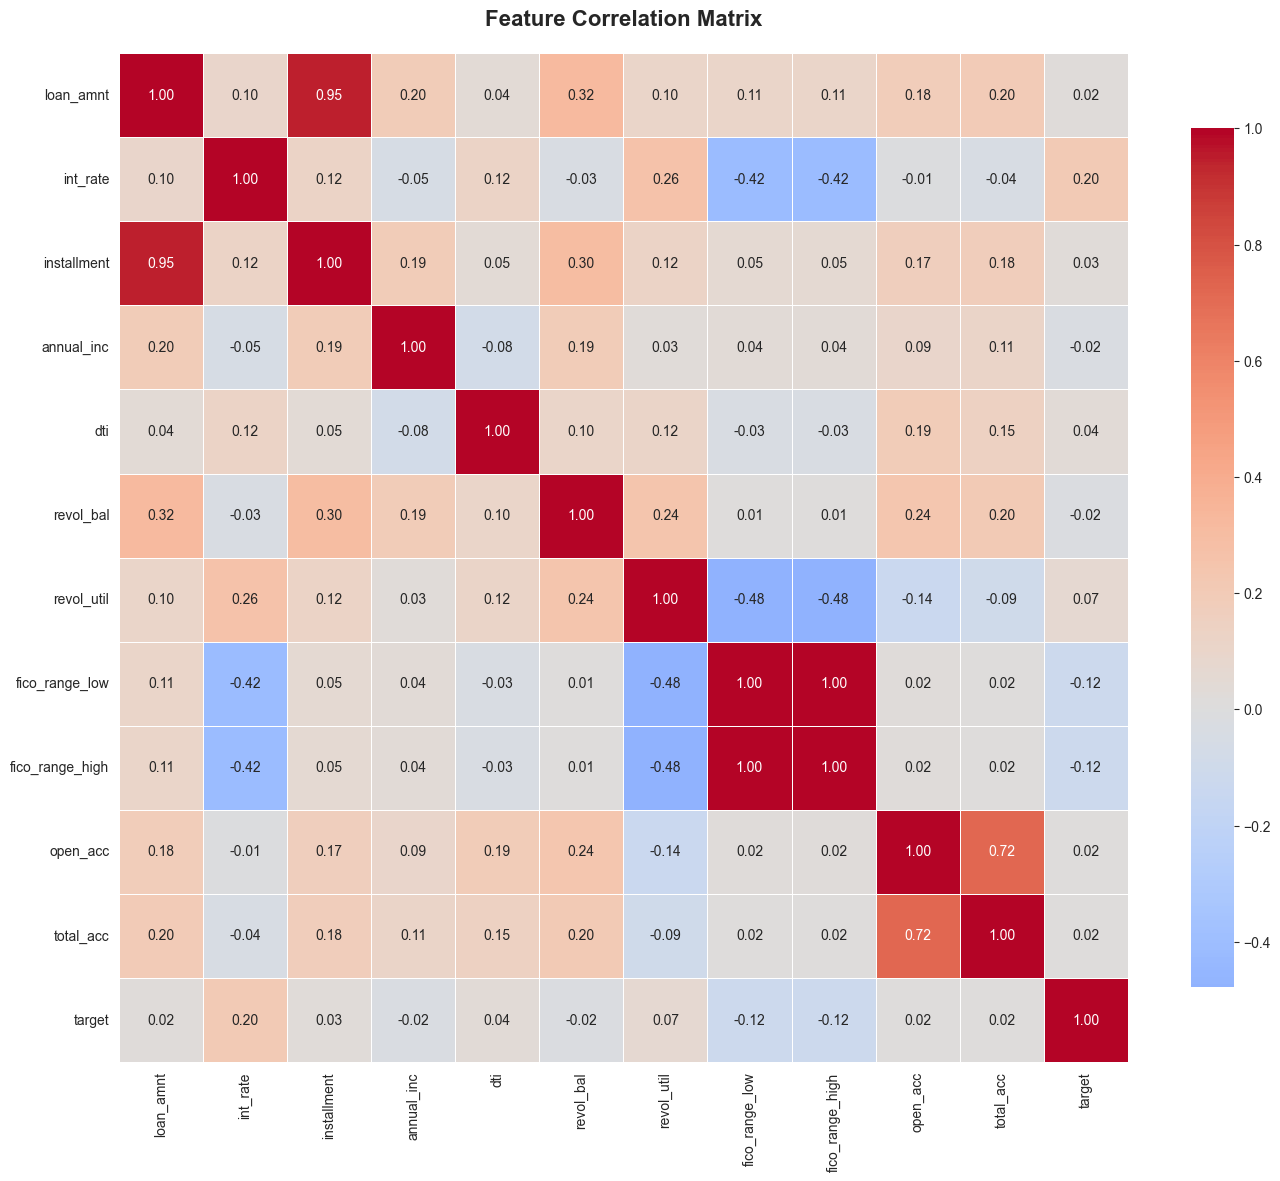


CORRELATION WITH TARGET (DEFAULT)

Top positive correlations:
int_rate           0.204416
revol_util         0.066405
dti                0.035477
installment        0.027570
loan_amnt          0.021575
open_acc           0.018694
total_acc          0.016222
revol_bal         -0.020818
annual_inc        -0.024892
fico_range_high   -0.121824
Name: target, dtype: float64

Top negative correlations:
revol_util         0.066405
dti                0.035477
installment        0.027570
loan_amnt          0.021575
open_acc           0.018694
total_acc          0.016222
revol_bal         -0.020818
annual_inc        -0.024892
fico_range_high   -0.121824
fico_range_low    -0.121826
Name: target, dtype: float64


In [33]:
# Select numeric columns for correlation
numeric_cols = df[key_features + ['target']].select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Top correlations with target
print("\n" + "="*60)
print("CORRELATION WITH TARGET (DEFAULT)")
print("="*60)
target_corr = corr_matrix['target'].drop('target').sort_values(ascending=False)
print("\nTop positive correlations:")
print(target_corr.head(10))
print("\nTop negative correlations:")
print(target_corr.tail(10))

## 9. Financial Metrics Analysis (for Reward Design)


FINANCIAL METRICS ANALYSIS (FOR RL REWARD DESIGN)

Financial metrics summary:
          loan_amnt   funded_amnt      int_rate   installment   total_pymnt  \
count  2.226416e+06  2.226416e+06  2.226416e+06  2.226416e+06  2.226416e+06   
mean   1.501409e+04  1.500874e+04  1.305479e+01  4.448701e+02  1.212351e+04   
std    9.177771e+03  9.175888e+03  4.814616e+00  2.667323e+02  9.921296e+03   
min    5.000000e+02  5.000000e+02  5.310000e+00  4.930000e+00  0.000000e+00   
25%    8.000000e+03  8.000000e+03  9.490000e+00  2.513600e+02  4.571100e+03   
50%    1.280000e+04  1.280000e+04  1.262000e+01  3.773700e+02  9.379065e+03   
75%    2.000000e+04  2.000000e+04  1.588000e+01  5.910200e+02  1.699332e+04   
max    4.000000e+04  4.000000e+04  3.099000e+01  1.719830e+03  6.329688e+04   

       total_rec_prncp  total_rec_int    recoveries  collection_recovery_fee  
count     2.226416e+06   2.226416e+06  2.226416e+06             2.226416e+06  
mean      9.560263e+03   2.415855e+03  1.460926e+02

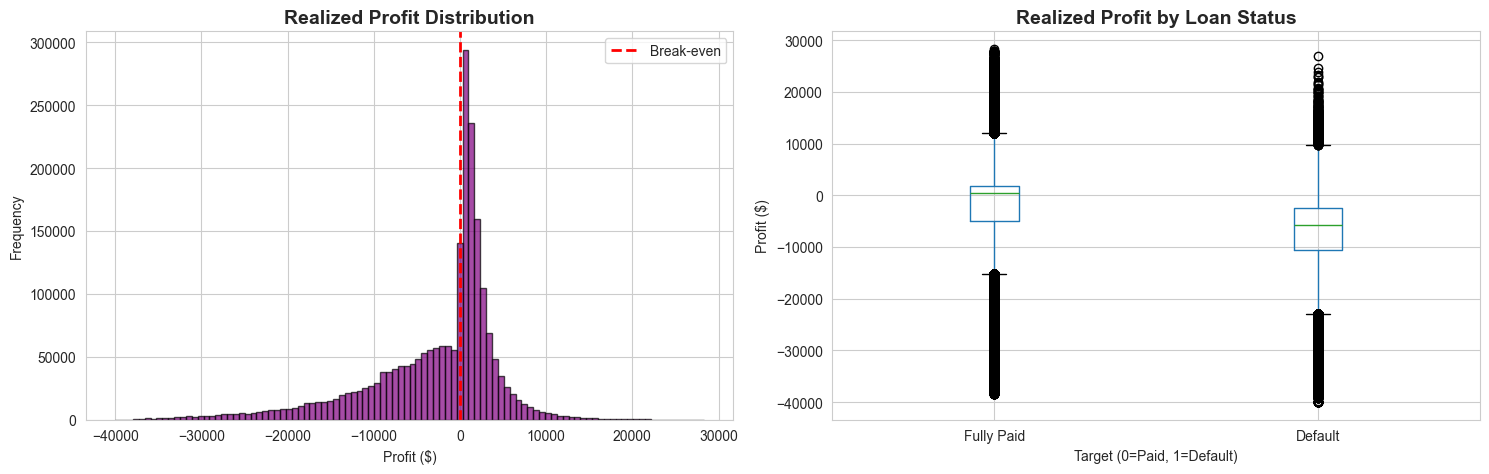


💡 Reward Function Design:
   - If action=1 (approve) and target=0: reward = total_rec_int
   - If action=1 (approve) and target=1: reward = -(loan_amnt - recoveries - collection_recovery_fee)
   - If action=0 (deny): reward = 0


In [34]:
# Key financial columns for reward calculation
financial_cols = ['loan_amnt', 'funded_amnt', 'int_rate', 'installment',
                  'total_pymnt', 'total_rec_prncp', 'total_rec_int',
                  'recoveries', 'collection_recovery_fee']

# Filter existing columns
financial_cols = [f for f in financial_cols if f in df.columns]

print("\n" + "="*60)
print("FINANCIAL METRICS ANALYSIS (FOR RL REWARD DESIGN)")
print("="*60)

print("\nFinancial metrics summary:")
print(df[financial_cols].describe())

# Calculate realized profit/loss per loan
if all(c in df.columns for c in ['total_pymnt', 'loan_amnt', 'recoveries', 'collection_recovery_fee']):
    df['realized_profit'] = df['total_pymnt'] - df['loan_amnt']
    
    print("\nRealized Profit Analysis:")
    print(f"  Mean profit per loan: ${df['realized_profit'].mean():,.2f}")
    print(f"  Median profit per loan: ${df['realized_profit'].median():,.2f}")
    print(f"  Std dev: ${df['realized_profit'].std():,.2f}")
    
    # By default status
    profit_by_status = df.groupby('target')['realized_profit'].describe()
    print("\nRealized Profit by Loan Status:")
    print(profit_by_status)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Profit distribution
    df['realized_profit'].hist(bins=100, ax=axes[0], color='purple', alpha=0.7, edgecolor='black')
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Break-even')
    axes[0].set_title('Realized Profit Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Profit ($)')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    
    # Profit by status
    df.boxplot(column='realized_profit', by='target', ax=axes[1])
    axes[1].set_title('Realized Profit by Loan Status', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Target (0=Paid, 1=Default)')
    axes[1].set_ylabel('Profit ($)')
    axes[1].set_xticklabels(['Fully Paid', 'Default'])
    plt.suptitle('')  # Remove auto title
    
    plt.tight_layout()
    plt.savefig('../reports/profit_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n💡 Reward Function Design:")
    print("   - If action=1 (approve) and target=0: reward = total_rec_int")
    print("   - If action=1 (approve) and target=1: reward = -(loan_amnt - recoveries - collection_recovery_fee)")
    print("   - If action=0 (deny): reward = 0")

## 10. Data Quality Issues

In [35]:
print("\n" + "="*60)
print("DATA QUALITY CHECKS")
print("="*60)

# Check for duplicates
n_duplicates = df.duplicated().sum()
print(f"\n1. Duplicate rows: {n_duplicates}")

# Check for negative values where they shouldn't exist
print("\n2. Negative values in financial columns:")
for col in ['loan_amnt', 'annual_inc', 'installment']:
    if col in df.columns:
        n_neg = (df[col] < 0).sum()
        if n_neg > 0:
            print(f"   ⚠️  {col}: {n_neg} negative values")
        else:
            print(f"   ✓ {col}: No negative values")

# Check for zero/null income
if 'annual_inc' in df.columns:
    zero_income = (df['annual_inc'] == 0).sum()
    print(f"\n3. Zero annual income: {zero_income} ({zero_income/len(df)*100:.2f}%)")

# Check FICO ranges
if 'fico_range_low' in df.columns and 'fico_range_high' in df.columns:
    invalid_fico = ((df['fico_range_low'] > df['fico_range_high']) | 
                    (df['fico_range_low'] < 300) | 
                    (df['fico_range_high'] > 850)).sum()
    print(f"\n4. Invalid FICO ranges: {invalid_fico}")

# Check for loans with total_pymnt < loan_amnt for 'Fully Paid' status
if 'total_pymnt' in df.columns and 'loan_amnt' in df.columns:
    fully_paid_mask = df['target'] == 0
    inconsistent = ((df.loc[fully_paid_mask, 'total_pymnt'] < 
                    df.loc[fully_paid_mask, 'loan_amnt'])).sum()
    print(f"\n5. 'Fully Paid' loans with total_pymnt < loan_amnt: {inconsistent}")
    print("   (These may be early payoffs or data errors)")


DATA QUALITY CHECKS

1. Duplicate rows: 0

2. Negative values in financial columns:
   ✓ loan_amnt: No negative values
   ✓ annual_inc: No negative values
   ✓ installment: No negative values

3. Zero annual income: 1632 (0.07%)

4. Invalid FICO ranges: 0

5. 'Fully Paid' loans with total_pymnt < loan_amnt: 788755
   (These may be early payoffs or data errors)

1. Duplicate rows: 0

2. Negative values in financial columns:
   ✓ loan_amnt: No negative values
   ✓ annual_inc: No negative values
   ✓ installment: No negative values

3. Zero annual income: 1632 (0.07%)

4. Invalid FICO ranges: 0

5. 'Fully Paid' loans with total_pymnt < loan_amnt: 788755
   (These may be early payoffs or data errors)


## 11. Recommended Feature Set

In [36]:
print("\n" + "="*60)
print("RECOMMENDED FEATURE SET FOR MODELING")
print("="*60)

# Core numeric features
recommended_numeric = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
    'revol_bal', 'revol_util', 'fico_range_low', 'fico_range_high',
    'open_acc', 'total_acc', 'delinq_2yrs', 'inq_last_6mths',
    'pub_rec', 'total_rev_hi_lim', 'avg_cur_bal'
]

# Core categorical features
recommended_categorical = [
    'term', 'grade', 'sub_grade', 'home_ownership',
    'verification_status', 'purpose', 'addr_state'
]

# Temporal features
recommended_temporal = [
    'issue_d', 'earliest_cr_line'
]

# Financial outcome features (for reward calculation only, NOT as input features)
reward_features = [
    'total_pymnt', 'total_rec_prncp', 'total_rec_int',
    'recoveries', 'collection_recovery_fee'
]

# Filter available features
available_numeric = [f for f in recommended_numeric if f in df.columns]
available_categorical = [f for f in recommended_categorical if f in df.columns]
available_temporal = [f for f in recommended_temporal if f in df.columns]
available_reward = [f for f in reward_features if f in df.columns]

print("\n✓ NUMERIC FEATURES (for model input):")
for f in available_numeric:
    missing_pct = df[f].isnull().mean() * 100
    print(f"   - {f:<25} (missing: {missing_pct:.1f}%)")

print("\n✓ CATEGORICAL FEATURES (for model input):")
for f in available_categorical:
    nunique = df[f].nunique()
    missing_pct = df[f].isnull().mean() * 100
    print(f"   - {f:<25} ({nunique} unique, missing: {missing_pct:.1f}%)")

print("\n✓ TEMPORAL FEATURES (for derived features):")
for f in available_temporal:
    print(f"   - {f}")

print("\n✓ FINANCIAL FEATURES (for reward calculation ONLY):")
for f in available_reward:
    print(f"   - {f}")

print("\n📝 DERIVED FEATURES TO CREATE:")
print("   - fico = (fico_range_low + fico_range_high) / 2")
print("   - loan_to_income = loan_amnt / (annual_inc + 1e-8)")
print("   - credit_age_years = (issue_d_year - earliest_cr_line_year)")
print("   - issue_year, issue_month (from issue_d)")

# Save feature lists for next notebook
feature_config = {
    'numeric': available_numeric,
    'categorical': available_categorical,
    'temporal': available_temporal,
    'reward': available_reward
}

import json
with open('../data/processed/feature_config.json', 'w') as f:
    json.dump(feature_config, f, indent=2)

print("\n✓ Feature configuration saved to ../data/processed/feature_config.json")


RECOMMENDED FEATURE SET FOR MODELING

✓ NUMERIC FEATURES (for model input):
   - loan_amnt                 (missing: 0.0%)
   - int_rate                  (missing: 0.0%)
   - installment               (missing: 0.0%)
   - annual_inc                (missing: 0.0%)
   - dti                       (missing: 0.1%)
   - revol_bal                 (missing: 0.0%)
   - revol_util                (missing: 0.1%)
   - fico_range_low            (missing: 0.0%)
   - fico_range_high           (missing: 0.0%)
   - open_acc                  (missing: 0.0%)
   - total_acc                 (missing: 0.0%)
   - delinq_2yrs               (missing: 0.0%)
   - inq_last_6mths            (missing: 0.0%)
   - pub_rec                   (missing: 0.0%)
   - total_rev_hi_lim          (missing: 3.2%)
   - avg_cur_bal               (missing: 3.2%)

✓ CATEGORICAL FEATURES (for model input):
   - term                      (2 unique, missing: 0.0%)
   - grade                     (7 unique, missing: 0.0%)
   - sub_grade

## 12. Summary & Next Steps

In [43]:
print("\n" + "="*60)
print("EDA SUMMARY & KEY FINDINGS")
print("="*60)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   - Total loans: {len(df):,}")
print(f"   - Features: {len(df.columns)}")
print(f"   - Time period: {df['issue_year'].min():.0f} - {df['issue_year'].max():.0f}" if 'issue_year' in df.columns else "   - Time period: Not available")
print(f"   - Default rate: {df['target'].mean()*100:.2f}%")

print(f"\n⚠️  CRITICAL FINDINGS:")
print(f"   1. Dataset contains ONLY ACCEPTED loans")
print(f"      → RL formulation: single action (approve) observed")
print(f"      → Need synthetic denials or model-based OPE")
print(f"   2. Class imbalance: {target_counts[0]/target_counts[1]:.1f}:1 ratio")
print(f"      → Use weighted loss and stratified splits")
print(f"   3. {len(high_missing_cols)} features with >50% missing")
print(f"      → Drop or handle carefully")

print(f"\n💰 PROFIT OPTIMIZATION INSIGHTS:")
print(f"   4. Grade A median profit >> Grade G median profit")
print(f"      → Higher grades consistently more profitable")
print(f"   5. Interest rate creates U-shaped risk profile:")
print(f"      → Low rate = low profit when paid")
print(f"      → High rate = high profit BUT high default risk")
print(f"      → Optimal rate balances risk vs reward")
print(f"   6. Financial crisis (2007-2008) shows 26% default spike")
print(f"      → Temporal split essential for realistic evaluation")
print(f"      → 2018 data artificially low (loans too recent)")

print(f"\n🎯 WHY REINFORCEMENT LEARNING MATTERS:")
print(f"   → Supervised models optimize ACCURACY (predict default)")
print(f"   → RL can optimize PROFIT (balance approval rate vs risk)")
print(f"   → Interest rate-profit tradeoff requires strategic decision-making")
print(f"   → This is a sequential decision problem, perfect for RL!")

print(f"\n✅ RECOMMENDED NEXT STEPS:")
print(f"   1. Preprocessing (notebook 02):")
print(f"      - Drop high-missing columns")
print(f"      - Create derived features (fico, loan_to_income, credit_age)")
print(f"      - Handle missing values (median/mode imputation)")
print(f"      - Encode categoricals (one-hot / target encoding)")
print(f"      - Scale numeric features (StandardScaler)")
print(f"      - Temporal split: train 2007-2016, val 2017, test 2018")
print(f"\n   2. Supervised baseline (notebook 03):")
print(f"      - PyTorch MLP with balanced loss")
print(f"      - Metrics: AUC, F1, Precision@k")
print(f"      - Profit-based threshold optimization")
print(f"\n   3. RL dataset creation (notebook 04):")
print(f"      - Convert to (s, a, r, s', done) format")
print(f"      - Reward: interest earned vs. loss from default")
print(f"      - Augment with synthetic denials (a=0, r=0)")
print(f"\n   4. Offline RL training (notebook 05):")
print(f"      - Try: TD3+BC, CRR, AWAC, CQL, IQL, BCQ")
print(f"      - Save checkpoints and metrics")
print(f"\n   5. Evaluation (notebook 06):")
print(f"      - FQE for policy value estimation")
print(f"      - Bootstrap CIs")
print(f"      - Compare supervised vs RL policies")
print(f"      - Counterfactual case studies")

print("\n" + "="*60)
print("EDA COMPLETE ✓")
print("="*60)


EDA SUMMARY & KEY FINDINGS

📊 DATASET OVERVIEW:
   - Total loans: 2,226,416
   - Features: 157
   - Time period: 2007 - 2018
   - Default rate: 12.10%

⚠️  CRITICAL FINDINGS:
   1. Dataset contains ONLY ACCEPTED loans
      → RL formulation: single action (approve) observed
      → Need synthetic denials or model-based OPE
   2. Class imbalance: 7.3:1 ratio
      → Use weighted loss and stratified splits
   3. 44 features with >50% missing
      → Drop or handle carefully

💰 PROFIT OPTIMIZATION INSIGHTS:
   4. Grade A median profit >> Grade G median profit
      → Higher grades consistently more profitable
   5. Interest rate creates U-shaped risk profile:
      → Low rate = low profit when paid
      → High rate = high profit BUT high default risk
      → Optimal rate balances risk vs reward
   6. Financial crisis (2007-2008) shows 26% default spike
      → Temporal split essential for realistic evaluation
      → 2018 data artificially low (loans too recent)

🎯 WHY REINFORCEMENT LEA